In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batoid
from LSSTFringe import utils,plot_utils,TMMSIM
index_of_refraction = utils.load_refraction_data(Epoxy_ind=1.6,Temp = 183.)
from astropy.io import fits
import os
from tqdm import tqdm
import random

In [2]:
telescope = batoid.Optic.fromYaml("LSST_y.yaml")

Paper Figure 10

(-4.5, 4.5, -1.0, 7.0)

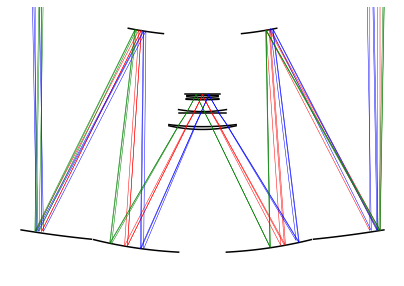

In [28]:
def ray_trace (thx_val,thy_val):
    # It's easier to specify an incoming field angle than a particular
    # spot on the focal plane, so we'll start there.
    thx = np.deg2rad(thx_val)
    thy = np.deg2rad(thy_val)
    wavelength = 900e-9 # meters
    rays = batoid.RayVector.asPolar(
        optic=telescope,
        wavelength=wavelength,
        theta_x=thx, theta_y=thy,
        nrad=500, naz=3000  #  These control how many parallel rays are created
    )
    # Make "full trace" of a small random subset of rays for visualization down 
    # below.  This isn't needed generally, it's just for the 3D vis below.

    MIN = 80000
    MAX = 80300
    tf_right = telescope.traceFull(rays[MIN:MAX][np.random.choice(len(rays[MIN:MAX]), 3)])

    MIN = 200000
    MAX = 200100
    tf_left = telescope.traceFull(rays[MIN:MAX][np.random.choice(len(rays[MIN:MAX]), 3)])
    return(tf_left,tf_right)

tf1,tf2 = ray_trace(0,0)
tf11,tf22 = ray_trace(0.8,1.2)
tf111,tf222 = ray_trace(-0.8,1.2)

# We can visualize all of this too:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-1, 7)
#ax.set_zlim(0, 10)
telescope.draw2d(ax, c='k')
batoid.drawTrace2d(ax, tf1, c='r', lw=0.5)
batoid.drawTrace2d(ax, tf2, c='r', lw=0.5)
batoid.drawTrace2d(ax, tf22, c='blue', lw=0.5)
batoid.drawTrace2d(ax, tf11, c='blue', lw=0.5)
batoid.drawTrace2d(ax, tf111, c='green', lw=0.5)
batoid.drawTrace2d(ax, tf222, c='green', lw=0.5)

plt.axis('off')

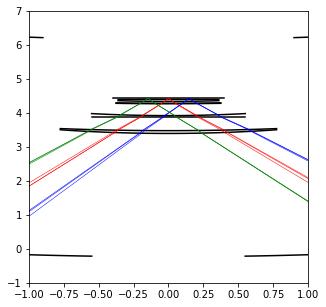

In [30]:
# We can visualize all of this too:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 7)
#ax.set_zlim(0, 10)
telescope.draw2d(ax, c='k')
batoid.drawTrace2d(ax, tf1, c='r', lw=0.5)
batoid.drawTrace2d(ax, tf2, c='r', lw=0.5)
batoid.drawTrace2d(ax, tf22, c='blue', lw=0.5)
batoid.drawTrace2d(ax, tf11, c='blue', lw=0.5)
batoid.drawTrace2d(ax, tf111, c='green', lw=0.5)
batoid.drawTrace2d(ax, tf222, c='green', lw=0.5)
#plt.axis('off')
plt.show()

In [3]:
thx = np.deg2rad(0)
thy = np.deg2rad(0)
wavelength = 960e-9 # meters
rays = batoid.RayVector.asPolar(
    optic=telescope,
    wavelength=wavelength,
    theta_x=thx, theta_y=thy,
    nrad=1000, naz=3000  #  These control how many parallel rays are created
)
# Make "full trace" of a small random subset of rays for visualization down 
# below.  This isn't needed generally, it's just for the 3D vis below.
tf = telescope.traceFull(rays[np.random.choice(len(rays), 30)])

# Now trace through the system
telescope.trace(rays)
# Limit to unvignetted rays
rays = rays[~rays.vignetted]

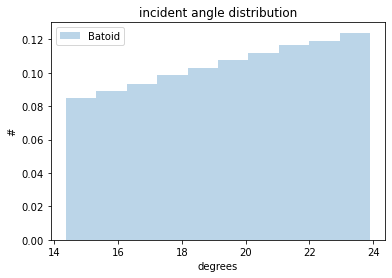

In [4]:
dxdz_batoid = rays.vx/rays.vz
dydz_batoid = rays.vy/rays.vz
#plt.hist(np.arctan(np.sqrt(dxdz**2+dydz**2))*180/np.pi,label = 'Fringing')

# We can convert these to a 1d histogram of incident angles
inc_thx, inc_thy = batoid.utils.dirCosToField(rays.vx, rays.vy, -rays.vz)
a,b,c= plt.hist(np.rad2deg(np.hypot(inc_thx, inc_thy)),label = 'Batoid',alpha = 0.3,density = True)
plt.xlabel("degrees")
plt.ylabel("#")
plt.legend(loc = 'best')
plt.title("incident angle distribution");

In [11]:
hh = fits.open('../AstroCCD-master/data/E2V-321.fits')
MAP = hh[1].data['sim']
MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)

In [7]:
dz = np.linspace(0., 100., 10000)

def decision(probability):
    return(True)
    #return random.random() < probability

def Fringe_sim (xz_slope,yz_slope,x_position,y_position):#,Results):
    
# x_position, y_position: the location photon hit the CCD
# Results: the array that stores the photon location and number
# N: Number of times needed for repeating, depending the incident angle distribution and sampling
#


    # location on the CCD

    # Wavelength
    wlen = 960
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    n_list = np.array([index_of_refraction[m](wlen) for m in material])
    
    travel_x = []
    travel_y = []
    travel_z = []
    for i in range(len(xz_slope)):
    
        # Extract Info corresoponds to the photon
        # Incident slope in x and y
        dxdz = xz_slope[i]
        dydz = yz_slope[i]
        
        # Derive the incident angle in the plane of incidence based on two slopes
        tan_phi = 1/(np.sqrt(dxdz**2+dydz**2))
        phi = (np.pi/2 - np.arctan(tan_phi))

        # Extract the epoxy thickness corresponding to this specific pixel
        epoxy_thickness = Fitting[int(x_position),int(y_position)]

        # Run fringing core simulation

        thickness_um = np.array([np.inf, 0.1221,0.0441,100., 0.1, 0.3,1.,epoxy_thickness,165, np.inf])
        pol = 's'
        results = TMMSIM.coh_tmm(pol, n_list, thickness_um, phi, wlen*1e-3)

        # Absorption probability in 100um Silicon 
        Abor_prob = TMMSIM.absorp_in_each_layer(results)[3]
        



        # Determine if the photon will be absorbed
        if decision(Abor_prob) == True:
            # calculate absorption as a function of z and 
            absor= TMMSIM.position_resolved(3, dz, results)[1]

            aa = absor/np.sum(absor) #Normalize
            
            # np.random.choice an absorption position
            z_dist = np.random.choice(a = dz,p = aa)
            
            sin_theta = dxdz * tan_phi
            cos_theta = dydz * tan_phi

            # Calculate the new slopes in Silicon layer
            new_phi = results[6][3].real
            new_dxdz = sin_theta*np.tan(new_phi)
            new_dydz = cos_theta*np.tan(new_phi)



            # Propagate the position travel in x and y direction, using values of  new_dxdz and new_dydz as direction indicator
            x_dist = new_dxdz * z_dist
            y_dist = new_dydz * z_dist
            
            # check if the photon will move to neighbouring pixels
            if abs(x_dist) > 5:
                x_new = x_position - np.sign(dxdz)*1
            else: 
                x_new = x_position
            if abs(y_dist) > 5:
                y_new = y_position - np.sign(dxdz)*1
            else:
                y_new = y_position
                
            travel_x.append(x_dist)
            travel_y.append(y_dist)
            travel_z.append(z_dist)
            # check if the photon's new position will hit the boarder 
            #if x_new < 0 or y_new < 0 or x_new > 199 or y_new > 199:
                # Discard if hitting go out of boarder
                #Results[0,0] += 0
            #else:
                # Else, count the photon in new position and update the array
                #Results[int(x_new),int(y_new)] += 1
            
            

    #return(Results)
    return(travel_x,travel_y,travel_z)
    

In [8]:
dxdz_batoid = rays.vx/rays.vz
dydz_batoid = rays.vy/rays.vz



x_index =  200
y_index =  200
choice = np.random.choice(len(dxdz_batoid),1000)
x_distance,y_distance,z_distance = Fringe_sim(xz_slope=dxdz_batoid[choice],yz_slope=dydz_batoid[choice], 
                          x_position = x_index, y_position = y_index)

Paper Figure 12

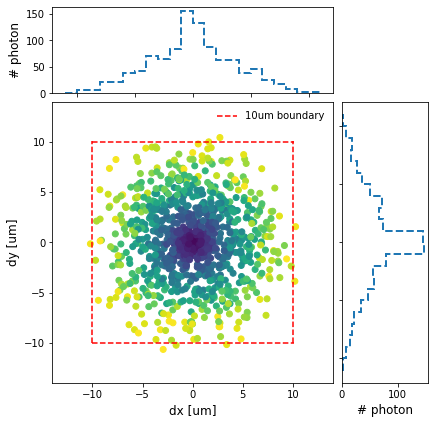

In [10]:
#import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

# the random data
x = x_distance
y = y_distance

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(6, 6))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)



# now determine nice limits by hand:
binwidth = 1
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth
axScatter.set_xlabel('dx [um]',fontsize = 12)
axScatter.set_ylabel('dy [um]',fontsize = 12)


bins = np.arange(-lim, lim + binwidth, binwidth)
# the scatter plot:
#axScatter.hist2d(x, y,bins = bins)
axScatter.scatter(x, y,c= z_distance)
axScatter.set_xlim((-14, 14))
axScatter.set_ylim((-14, 14))
axScatter.axhline(-10,xmin = 0.14,xmax= 0.86,color = 'red',ls = '--',label = '10um boundary')
axScatter.axhline(10,xmin = 0.14,xmax= 0.86,color = 'red',ls = '--')
axScatter.axvline(10,ymin = 0.14,ymax= 0.86,color = 'red',ls = '--')
axScatter.axvline(-10,ymin = 0.14,ymax= 0.86,color = 'red',ls = '--')

#axScatter.axhline(-5,xmin = 0.32,xmax= 0.68,color = 'red',ls = '-',label = '5um boundary')
#axScatter.axhline(5,xmin = 0.32,xmax= 0.68,color = 'red',ls = '-')
#axScatter.axvline(5,ymin = 0.32,ymax= 0.68,color = 'red',ls = '-')
#axScatter.axvline(-5,ymin = 0.32,ymax= 0.68,color = 'red',ls = '-')

axScatter.legend(loc = 'best',frameon = False)


axHistx.hist(x, bins=bins,linewidth = 2,histtype = 'step',ls ='--')
axHisty.hist(y, bins=bins, linewidth = 2,orientation='horizontal',histtype = 'step',ls = '--')
axHistx.set_ylabel('# photon',fontsize = 12)
axHisty.set_xlabel('# photon',fontsize = 12)


#axHistx.set_xlim(axScatter.get_xlim())
#axHisty.set_ylim(axScatter.get_ylim())

plt.savefig('../AstroCCD-master/data/Paper_plots/ab_photon_dist_center.eps')